# Description
Find the actual component values of the coil and capacitor in the bandpass filter in fig. 1.

The following steps are required:

1. Compare the measured response voltage $U_a$ with the predicted response voltage under nominal component values.
2. Determine the root mean square error (rmse). 
3. Calculate the rmse for different values of $L$ and $C$.
4. Minimize the rmse function to find the actual component values.

![Circuit Diagramm](circuit.png)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
# import pandas as pd
import scipy as sci

# Get Data

In [2]:
COIL_NOMINAL=9e-3
CAPACITOR_NOMINAL=1000e-6

def get_measured_data(filename: str) -> dict[str, list[float]]:    
    """
    Import measured data from file and return as a dictionary.

    Input: name of the file where the measured data is stored. File must be npz or npy encoded. Column names must be "t_mess" and "u_a_mess".
    Output: a DataFrame containing the measured data.
    """
    with np.load(filename) as file:
        return {"time" : file["t_mess"], "measured" : file["u_a_mess"]}

def predict_voltage(coil: float, capacitor: float) -> list[float]:
    """
    Create a LTI System with a transfer function dependent on the resistors and return the output voltage of that system.

    Input: the values for the coil and capacitor in H and F.
    Output: A 1D list of the output voltage at time steps specified by the measured data points.
    """
    # constants in fig 1.
    RESISTOR=20
    INPUT_VOLTAGE = 2

    numerator=[1/(RESISTOR*capacitor), 0]
    denominator=[1, 1/(RESISTOR*capacitor), 1/(coil*capacitor)]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    # calculated the output voltage at time points from the measured data.
    return INPUT_VOLTAGE*sci.signal.step(transfer_function, T=u_a["time"])[1]

u_a = get_measured_data("messwerte.npz")
u_a["predicted"] = predict_voltage(COIL_NOMINAL, CAPACITOR_NOMINAL) # append dictionary with predicted values

# Analysis
## Plot Expected and Measured Data

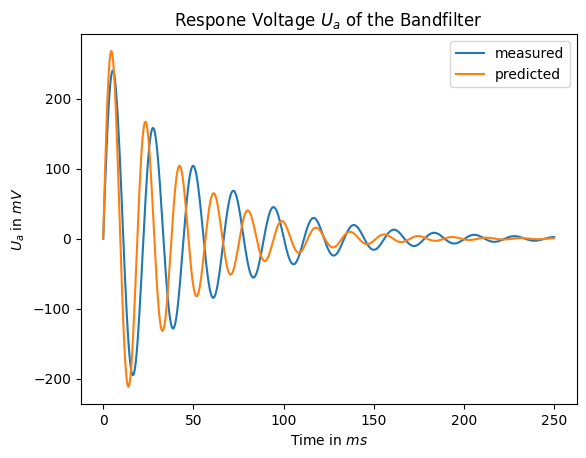

In [3]:
def plot_ua():
    """
    Plot u_a in as a line graph and change the magnitude by 10*-3.
    """
    plt.plot(u_a["time"]*10**3, u_a["measured"]*10**3, label="measured")
    plt.plot(u_a["time"]*10**3, u_a["predicted"]*10**3, label='predicted')

    plt.title("Respone Voltage $U_a$ of the Bandfilter")
    plt.xlabel("Time in $ms$")
    plt.ylabel("$U_a$ in $mV$")
    plt.legend()

plot_ua()

## Calculate Root Mean Square Error

In [4]:
def root_mean_square_error(predicted_voltage: list[float]) -> float: 
    """
    Calculate the root mean square error of the input list compared to the measured data of u_a.

    Input: Input Voltage as a list.
    Output: Root mean square error of the input voltage comparing input to measured data. Rounded to 2 decimal places.
    """
    rsme = np.sqrt(1/len(predicted_voltage) * np.sum(np.square(np.subtract(predicted_voltage, u_a["measured"]))))
    return np.round(rsme, 2)

rsme_nominal = root_mean_square_error(u_a["predicted"])
print(f"RSME with nominal values: {rsme_nominal*10**3} mV")

RSME with nominal values: 60.0 mV


# Find true Capacitor and Coil Values

## Create RSME Grid for Different Values

In [5]:
STEPS = 40
COIL_LOWER = 7e-3
COIL_UPPER = 12e-3
CAPACITOR_LOWER = 9 * 100e-6
CAPACITOR_UPPER = 16 * 100e-6

def resistor_range(lower: float, upper: float, steps: int) -> np.ndarray:
    """
    Create a list of resistor values.
    """
    return np.linspace(lower, upper, steps)

def create_rsme_grid(coil_list: list[float], capacitor_list : list[float]) -> np.ndarray:
    """
    Calculate the RSME for all pairs of capacitor and coil values. The voltage is calculated with the resistor values and compared to the measured data.

    Input: 1D list of capacitor values in F, 1d list of coil values in H.
    Output: A 2D matrix assigning a root mean square error for all positions x,y. x-axis is the coil values, y-axis is the capacitor values. 
    """
    # reserve array space
    rsme = np.zeros((len(coil_list), len(capacitor_list))) 

    # calculate rsme for all input pairs
    for i in range(len(coil_list)):
        for j in range(len(capacitor_list)):
            voltage = predict_voltage(coil_list[i], capacitor_list[j])
            rsme[i][j] = root_mean_square_error(voltage)

    return rsme

coil_range = resistor_range(COIL_LOWER, COIL_UPPER, STEPS)
capacitor_range = resistor_range(CAPACITOR_LOWER, CAPACITOR_UPPER, STEPS)

rsme_grid = create_rsme_grid(coil_range, capacitor_range)

## Plot RSME Contour and Surface

C:\Users\janho\AppData\Local\Temp\ipykernel_11200\2479704382.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(coil_range*10**3, capacitor_range*10**3, rsme_grid*10**3, label="RSME")


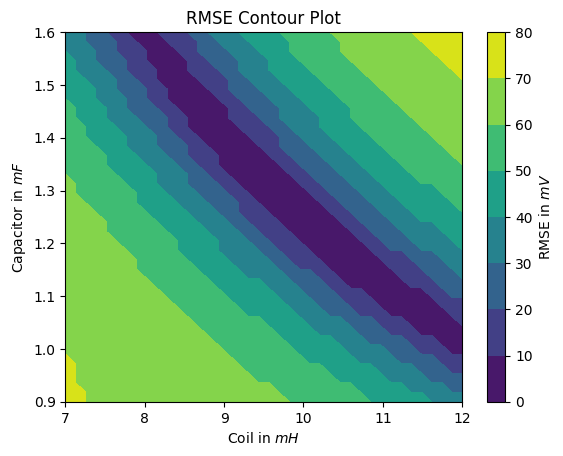

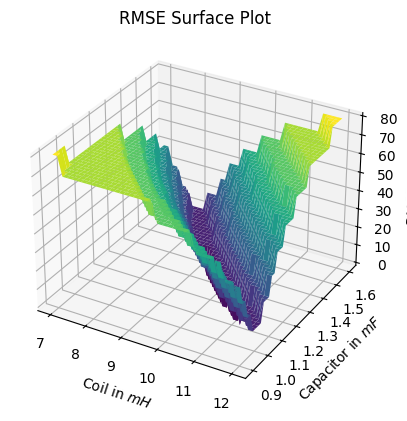

In [6]:
def plot_rsme():
    """
    Plot RSME as 3D colormap and change the magnitude by 10**-3.
    """
    plt.contourf(coil_range*10**3, capacitor_range*10**3, rsme_grid*10**3, label="RSME")

    plt.title('RMSE Contour Plot')
    plt.xlabel('Coil in $mH$')
    plt.ylabel('Capacitor in $mF$')
    plt.colorbar(label='RMSE in $mV$')

plot_rsme()

def plot_rsme_3d():
    """
    Plot RSME as 3D height map and change the magnitude by 10**-3.
    """
    x,y = np.meshgrid(coil_range, capacitor_range)
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_surface(x*10**3, y*10**3, rsme_grid*10**3, cmap='viridis')
    plt.title('RMSE Surface Plot')
    ax.set_xlabel('Coil in $mH$')
    ax.set_ylabel('Capacitor in $mF$')
    ax.set_zlabel('RMSE in mV')

plot_rsme_3d()

## Minimize rsme with variable parameters

In [7]:
def rsme_singel_input(params):
    # redefine rms function to work with a single input variable.
    # params is a 1d array. first element is the coil, second element is the capacitor.

    RESISTOR=20
    INPUT_VOLTAGE = 2

    numerator=[1/(RESISTOR*params[1]), 0]
    denominator=[1, 1/(RESISTOR*params[1]), 1/(params[0]*params[1])]
    transfer_function=sci.signal.TransferFunction(numerator, denominator)

    voltage =  INPUT_VOLTAGE*sci.signal.step(transfer_function, T=u_a["time"])[1]

    return root_mean_square_error(voltage)

def rsme_min():
    INITIAL_GUESS = [COIL_NOMINAL, CAPACITOR_NOMINAL]
    BOUNDS = [(COIL_LOWER, COIL_UPPER),(CAPACITOR_LOWER, CAPACITOR_UPPER)]

    # ! rsme function retuns discrete values. So minimize can't calculate a gradient. 
    return sci.optimize.dual_annealing(rsme_singel_input, BOUNDS, x0=INITIAL_GUESS)
    # return sci.optimize.minimize(rsme_singel_input, initial_guess, tol = 1e-15)

rsme_min = rsme_min()

best_coil, best_capacitor = np.round(rsme_min.x, 5)
this_rsme = np.round(rsme_min.fun,5)

print(f"True Coil:\t{best_coil*10**3} mH ")
print(f"True Capacitor:\t{best_capacitor*10**3} mF")
print(f"Minimum RMSE:\t{this_rsme*10**3} mV")

True Coil:	9.790000000000001 mH 
True Capacitor:	1.27 mF
Minimum RMSE:	0.0 mV


# Find all possible parameters so that $RSME$ = 0

## Find Frequency of $U_{a,measured}$ with Fast Fourier Transformation

Frequency of U_a measured:  43.91  Hz


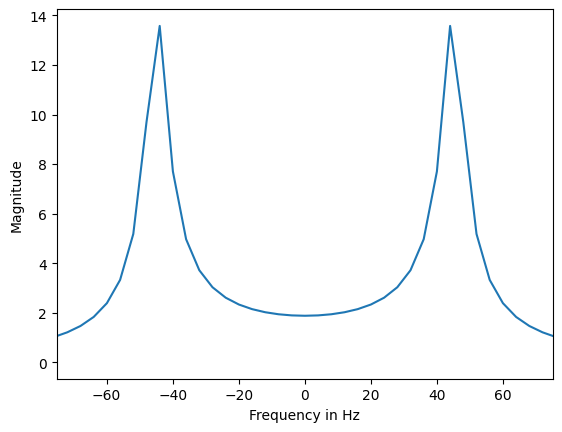

In [8]:
def find_frequency():
    fourier = np.fft.fft(u_a["measured"])
    dt = u_a["time"][1] - u_a["time"][0]
    n = u_a["time"].size
    frequency = np.fft.fftfreq(n, d=dt)

    id_max = np.argmax(np.abs(fourier))
    frequency_max = round(frequency[id_max], 2)
    print("Frequency of U_a measured: ", frequency_max, " Hz")

    plt.plot(np.fft.fftshift(frequency), np.fft.fftshift(abs(fourier)))
    plt.xlim(-75, 75)
    plt.xlabel("Frequency in Hz")
    plt.ylabel("Magnitude")
    plt.show()
    return frequency_max

frequency = find_frequency()

## Model RSME for known optimal Capacitor and Coil Values

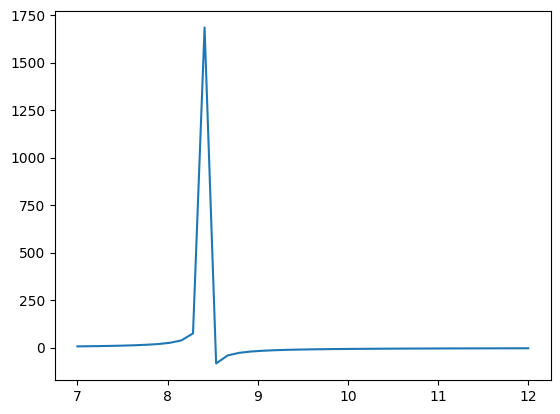

In [9]:
def capacitor_best(coil):
    capacitor = (7.71734*10**11)/(-76167098027154752 * coil + 641042574798611)
    return capacitor

capacitor_best = capacitor_best(coil_range)

rsme_var_coil = create_rsme_grid(coil_range, capacitor_best)

# plt.contourf(coil_list*10**3, capacitor_best*10**3, rsme_var_coil*10**3)
# plt.ylim(0.9, 1.6)
# plt.colorbar()

plt.plot(coil_range*10**3, capacitor_best*10**3)
# plt.ylim(0.9, 1.6)


# !!! Lösung für letzte Aufgabe: rsme ist minimal, wenn nullpunktdurchgänge identisch sind.
# !!! Ua muss gleiche Frequenz haben.
# !!! https://de.wikipedia.org/wiki/Thomsonsche_Schwingungsgleichung diese gleichung ist die antwort!!!!!!!!!!!

# Closing Notes

The RSME function is minimal when the calculted voltage is (almost) identical to the measured voltage. The coordinates of the global minimum are the true hardware parameters of C and L.

This is true of for all pairs of C and L that produce the same transferfunction  